# Production of Animal Products in Mainland China
# 中国大陆动物产品的生产情况

## Ready to work  准备

### Import Libraries 导入工具库

In [1]:
# import necessary libs

import os
import time
import datetime
import json
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms

import seaborn as sns

from scipy import stats

from bs4 import BeautifulSoup

import folium
from folium import plugins

from matplotlib_venn import venn2, venn3, venn3_circles

%matplotlib inline

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

In [2]:
# what is the relevant path of root
root_where = '../../'

# print('+++++++++ Attention ++++++++++')
# print(f'The root is set as "{root_where}" relevant to this file.' )
# print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
# print('+++++++++++++++++++++++++++++')
# print('')

LOCAL_ROOT = os.path.abspath(root_where)

DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
DATA_FAO = os.path.join(DATA_BASE, 'FAO')
DATA_NBS = os.path.join(DATA_BASE, 'NBS')
DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')

NBS_meta = os.path.join(DATA_NBS, 'metadata')

FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'

# print(f'Root director: {LOCAL_ROOT}')
# print(f'Data director: {DATA_BASE}')
# print(f'FAO data director: {DATA_FAO}')
# print(f'NBS data director: {DATA_NBS}')
# print(f'Hybrids data director: {DATA_hybrids}')
# print('')
# print(f'NBS metadata director: {NBS_meta}')
# print('')
# print(f'FAO metadata director: {FAO_meta}')
# print(f'FAO local description file: {FAO_description_path}')
# print(f'FAO local data zip: {FAO_BULK_zip}')
# print('')

SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
print(f'Suffix of raw FAO data file name: {SUFFIX}')

Suffix of raw FAO data file name: _E_All_Data_(Normalized)


In [3]:
domain = 'CN_AnimalProduction'

path_img = f'{LOCAL_ROOT}/results/{domain}/img/'
path_map = f'{LOCAL_ROOT}/results/{domain}/map/'

for i in os.listdir(path_img):
    path_file = os.path.join(path_img,i)  
    if os.path.isfile(path_file):
          os.remove(path_file)
            
for i in os.listdir(path_map):
    path_file = os.path.join(path_map,i)
    if os.path.isfile(path_file) and path_file.endswith(".html"):
          os.remove(path_file)

### Plot style settings 设置输出风格

In [4]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (5,3)
DPI = 144

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

# Color setting ===================================================================

# 猪，牛，羊，禽肉，鱼，蛋，奶
Pig_pink = '#ffab91'
Bovine_red = '#c62828'
Lamb_green = '#689f38'
Bird_orange = '#ff6f00'
Aqua_cyan = '#80deea'
Egg_yellow = '#ffc400'
Milk_blue = '#1e88e5'

# Good Food
GF_brand_gold = '#fdd835'
GF_brand_gray = '#9F888C'

GF_amber1 = '#ffe57f'
GF_amber2 = '#ffab00'

GF_red0 = '#ffebee'
GF_red1 = '#ff8a80'
GF_red2 = '#d50000'

GF_green2 = '#00c853'
GF_green1 = '#b9f6ca'

GF_blue1 = '#82b1ff'
GF_blue2 = '#2962ff'

# Gray
Gray1 = '#eeeeee'
Gray2 = '#bdbdbd'
Gray3 = '#666666'

CLs = [Pig_pink, Bovine_red, Lamb_green, Bird_orange, Aqua_cyan, Egg_yellow,  Milk_blue]

MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

### Read Data Frame 读取数据

- 'MeatProduction_clean.csv' is the data needed in this program. See how the data was obtained and cleaned: [CN_AnimalProduction_DataCleaning](CN_AnimalProduction_DataCleaning);

- 'AnimalProduction_clean_doc.csv' explains the data's feilds;

- 'GeoNameSheet_cn.csv' lists all the mainland China's areas;

In [5]:
data = pd.read_csv(DATA_hybrids+'/AnimalProduction_clean.csv')
doc = pd.read_csv(DATA_hybrids+'/AnimalProduction_doc.csv')
geoname = pd.read_csv(NBS_meta+'/GeoNameSheet_cn.csv')
display(doc)
display(data.head())
display(geoname.head())
# display(data.head())
# display(geoname.head())

,Item-En,项目名称: Item_Cn,Explanation-En,中文解释: Explanation-Cn,Unit-En,单位: Unit-Cn,Remarek-En,备注: Remark-Cn
0,Area,地区,"Name of countries, areas or China's provinces (or provincial level areas of China)",国家、地区或中国省份（或中国省级地区）的名字；,10000 heads,万头,NaN,NaN
1,Year,年份,Years.,年份,10000 heads,万头,NaN,NaN
2,"Stock, cattle",存栏量_牛,Numbers of stocks of cattle.,牛的存栏量,10000 heads,万头,NaN,NaN
3,"Stock, goat & sheep",存栏量_山羊&绵羊,Numbers of stocks of the total of goats and sheep.,山羊和绵羊的总存栏量,10000 heads,万头,NaN,NaN
4,"Stock, pig",存栏量_猪,Numbers of stocks of pigs.,猪的存栏量,10000 heads,万头,NaN,NaN
5,"Stock, birds",存栏量_禽类,Numbers of stocks of birds.,禽类的存栏量,10000 heads,万头,"Areas data estimated by (each year's 'Slaughtered, birds' of cn / each year's 'Stock, birds' of...",地方数据根据 (每年全国'屠宰量_禽类' / 每年全国'存栏量_禽类' = 同年各地'屠宰量_禽类' /同年各地'存栏量_禽类') 估算
6,"Slaughtered, cattle",屠宰量_牛,Numbers of slaughtered cattle for meat.,牛的屠宰数量（出栏量）,10000 heads,万头,NaN,NaN
7,"Slaughtered, goat & sheep",屠宰量_山羊&绵羊,Numbers of slaughtered goats and sheep for meat.,山羊和绵羊的屠宰数量（出栏量）,10000 heads,万头,NaN,NaN
8,"Slaughtered, pig",屠宰量_猪,Numbers of slaughtered pigs for meat.,猪的屠宰数量（出栏量）,10000 heads,万头,NaN,NaN
9,"Slaughtered, birds",屠宰量_禽类,"Numbers of slaughtered birds for meat, mainly from chicken and duck.",禽类的屠宰数量（出栏量）,10000 heads,万头,NaN,NaN


,Area,Year,"Stock, cattle","Stock, goat & sheep","Stock, pig","Stock, birds","Slaughtered, cattle","Slaughtered, goat & sheep","Slaughtered, pig","Slaughtered, birds","Meat Production, cattle","Meat Production, goat & sheep","Meat Production, pig","Meat Production, birds","Egg Production, birds","Milk Production, cow","Meat Yield, cattle","Meat Yield, goat & sheep","Meat Yield, pig","Meat Yield, birds","Aquatic Production, total","Aquatic Production, animals","Marine, total","Marine, capture","Marine, aquac.",Marine Fish,Marine Crustaceans,Marine Molluscs,Marine Plants,"Marine, others","Freshwater, total","Freshwater, capture","Freshwater, aquac.",Freshwater Fish,Freshwater Crustaceans,Freshwater Molluscs,"Freshwater, others"
0,"China, mainland",1961,4940.0,11281.0,8227.0,62600.0,50.6,1000.0,3300.0,54500.0,4.3,10.0,137.0,57.00,150.0,60.0,85.0,10.000000,41.5,1.045872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"China, mainland",1962,4676.0,12387.0,7552.0,64200.0,69.0,1000.0,4300.0,56400.0,6.2,10.0,178.0,59.00,152.0,62.0,89.9,10.000000,41.4,1.046099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"China, mainland",1963,4736.0,13465.0,9997.0,66300.0,92.5,1200.0,7800.0,58000.0,8.3,12.0,330.0,60.75,154.0,63.5,89.7,10.000000,42.3,1.047414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"China, mainland",1964,4894.0,13747.0,13180.0,68400.0,103.5,1400.0,10500.0,59400.0,9.3,14.0,450.0,62.25,158.0,64.0,89.9,10.000000,42.9,1.047980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"China, mainland",1965,5242.0,13669.0,15247.0,69000.0,116.0,1570.0,12167.0,61600.0,10.4,16.0,525.0,64.50,162.0,64.5,89.7,10.191083,43.1,1.047078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Area Code,Area,Region
0,41,"China, mainland",East Asia
1,1001,Beijing,North China
2,1002,Tianjin,North China
3,1003,Hebei,North China
4,1004,Shanxi,North China


In [6]:
data = pd.merge(geoname, data, on='Area', how='outer')

print('The shape and the head of the data frame:')
print(data.shape)
display(data.head())

The shape and the head of the data frame:
(677, 39)


,Area Code,Area,Region,Year,"Stock, cattle","Stock, goat & sheep","Stock, pig","Stock, birds","Slaughtered, cattle","Slaughtered, goat & sheep","Slaughtered, pig","Slaughtered, birds","Meat Production, cattle","Meat Production, goat & sheep","Meat Production, pig","Meat Production, birds","Egg Production, birds","Milk Production, cow","Meat Yield, cattle","Meat Yield, goat & sheep","Meat Yield, pig","Meat Yield, birds","Aquatic Production, total","Aquatic Production, animals","Marine, total","Marine, capture","Marine, aquac.",Marine Fish,Marine Crustaceans,Marine Molluscs,Marine Plants,"Marine, others","Freshwater, total","Freshwater, capture","Freshwater, aquac.",Freshwater Fish,Freshwater Crustaceans,Freshwater Molluscs,"Freshwater, others"
0,41,"China, mainland",East Asia,1961,4940.0,11281.0,8227.0,62600.0,50.6,1000.0,3300.0,54500.0,4.3,10.0,137.0,57.00,150.0,60.0,85.0,10.000000,41.5,1.045872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41,"China, mainland",East Asia,1962,4676.0,12387.0,7552.0,64200.0,69.0,1000.0,4300.0,56400.0,6.2,10.0,178.0,59.00,152.0,62.0,89.9,10.000000,41.4,1.046099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41,"China, mainland",East Asia,1963,4736.0,13465.0,9997.0,66300.0,92.5,1200.0,7800.0,58000.0,8.3,12.0,330.0,60.75,154.0,63.5,89.7,10.000000,42.3,1.047414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,41,"China, mainland",East Asia,1964,4894.0,13747.0,13180.0,68400.0,103.5,1400.0,10500.0,59400.0,9.3,14.0,450.0,62.25,158.0,64.0,89.9,10.000000,42.9,1.047980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41,"China, mainland",East Asia,1965,5242.0,13669.0,15247.0,69000.0,116.0,1570.0,12167.0,61600.0,10.4,16.0,525.0,64.50,162.0,64.5,89.7,10.191083,43.1,1.047078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Show the latest year of data and store the value to 'DATA_YEAR'

In [7]:
"""
the items include:
    'Meat Production, pig', 'Meat Production, cattle', 'Meat Production, goat & sheep',
    'Meat Production, birds', 'Aquatic, animals', 
    'Egg Production, birds', 'Milk Production, cow'
the latest year of data will be stored in variable 'DATA_YEAR'
"""

Is = [
    'Meat Production, pig', 'Meat Production, cattle', 'Meat Production, goat & sheep',
    'Meat Production, birds', 'Aquatic Production, animals', 
    'Egg Production, birds','Milk Production, cow',
]                                   # Items, data in these columns will be visualized

Is_productivity = [
    'Slaughtered, pig', 'Stock, pig', 'Meat Yield, pig',
    'Slaughtered, cattle', 'Stock, cattle', 'Meat Yield, cattle',
    'Slaughtered, goat & sheep', 'Stock, goat & sheep', 'Meat Yield, goat & sheep',
    'Slaughtered, birds', 'Stock, birds', 'Meat Yield, birds',
]
Is_aquatic = ['Marine, capture', 'Marine, aquac.', 'Freshwater, capture', 'Freshwater, aquac.']


DATA = data[['Area Code', 'Area', 'Year']+Is+Is_productivity+Is_aquatic]
DATA = DATA.dropna().drop_duplicates()

Years = DATA['Year'].unique()               
print ('The datasets years cover: ', Years)

The datasets years cover:  [1978 1980 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017]


## Results 结果
### Production Trends of Animal Products in Mainland China 
### 中国大陆动物产品产量趋势

- Create line plot to show Production Trends of Animal Products;
- As well as stacked bar plots (in absolute values and in percentages).

,Area,Year,"Meat Production, pig","Meat Production, cattle","Meat Production, goat & sheep","Meat Production, birds","Aquatic Production, animals","Egg Production, birds","Milk Production, cow"
17,"China, mainland",1978,8.048000,0.184,0.320,1.095,4.3960,2.520,1.100
19,"China, mainland",1980,11.341000,0.235,0.450,1.180,4.2353,2.800,1.141
24,"China, mainland",1985,16.547000,0.345,0.593,1.390,6.7786,5.347,2.499
25,"China, mainland",1986,17.167000,0.450,0.622,1.645,8.0030,5.550,2.899
26,"China, mainland",1987,18.349008,0.648,0.719,1.920,9.3170,5.902,3.301


Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/01-Outputs of Animal Produced Food in China (mainland)-line.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/01-Outputs of Animal Produced Food in China (mainland)-bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/01-Percentages (%) of Outputs of Animal Produced Food in China (mainland).png


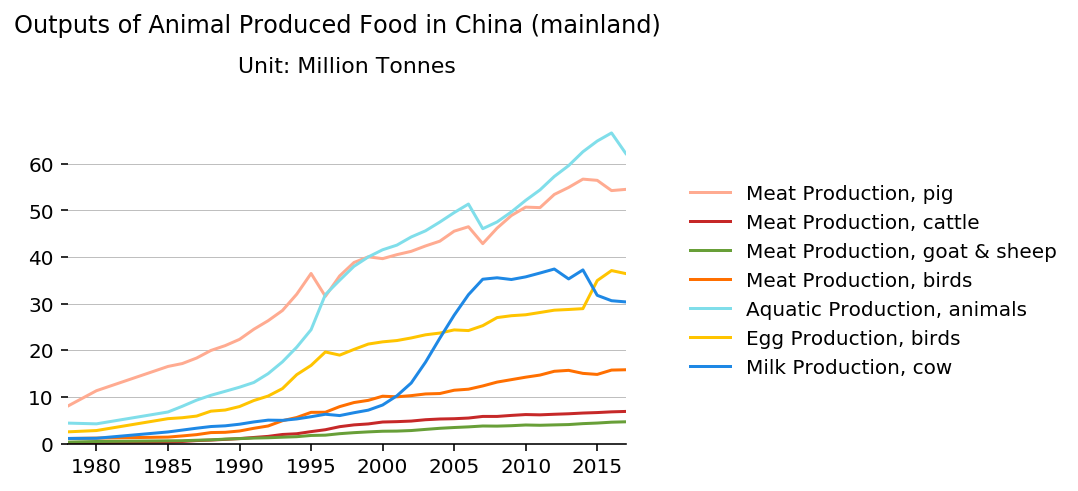

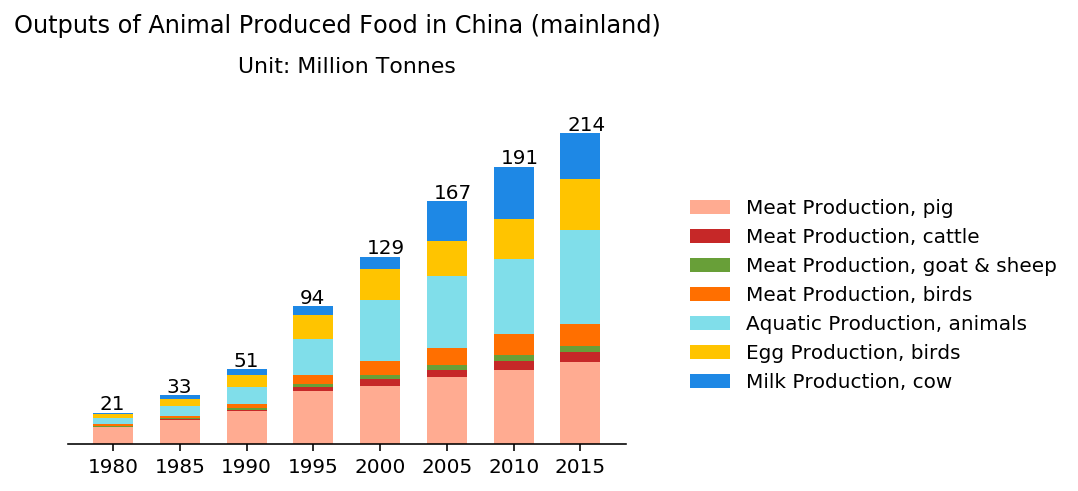

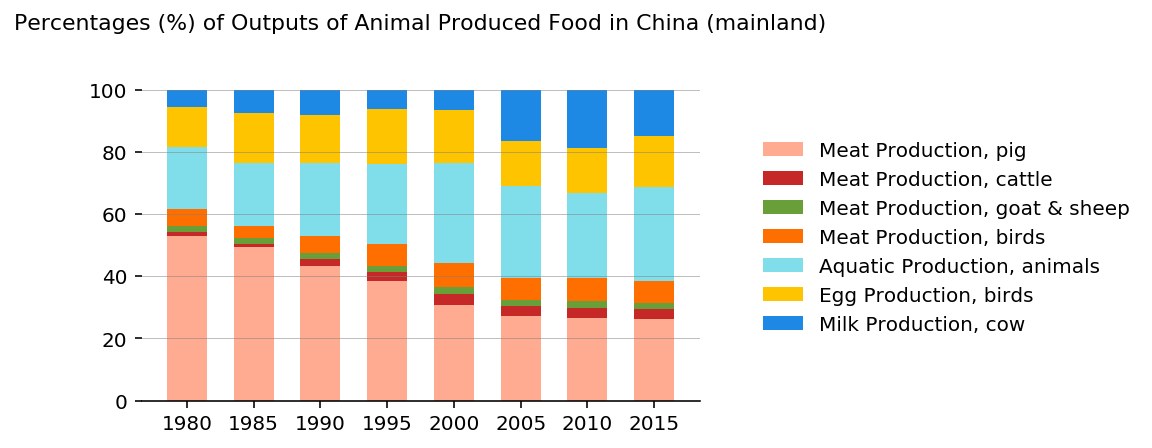

In [8]:
area='China, mainland'
unit='Million Tonnes'
items=Is
fig_size=FIG_size

df=DATA[['Area', 'Year']+Is].copy()

if unit == '': 
    sub_title = "Unit: 10,000 Tonnes"
elif unit=='Million Tonnes':
    df[items] = df[items]/100
    sub_title = f"Unit: {unit}"

df = df[df['Area']=='China, mainland']

display(df.head())

# X values
X_step = 5
X_ticks = range(1980, 2015+X_step, X_step)
# ===================================Line

title = "Outputs of Animal Produced Food in China (mainland)"

fig = plt.figure(figsize=fig_size, dpi=DPI)
plt.suptitle(title, fontsize=TIT_size, y=1.12)
plt.title(sub_title, fontsize=TIT_size-1, y=1.1)

for i,c in zip(items, CLs):
    df.plot.line(x='Year', y=i, color=c, ax=plt.gca())

ax = plt.gca()
ax.xaxis.label.set_visible(False)
ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.5)
ax.set_ylim(0,)

ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(
    loc='center left', frameon=False, fontsize=LEG_size,
    bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
)

path = f'{LOCAL_ROOT}/results/{domain}/img/01-{title}-line.png'
bbox = matplotlib.transforms.Bbox([[-0.5, 0], [fig_size[0]+3, fig_size[1]+1]])
fig.savefig(path, format='png', transparent=True, dpi=DPI, bbox_inches =bbox)
print('Img saved as: ' + path)

# =====================Bar
fig = plt.figure(figsize=fig_size, dpi=DPI)
plt.suptitle(title, fontsize=TIT_size, y=1.12)
plt.title(sub_title, fontsize=TIT_size-1, y=1.1)

# Y Total for notation
bot=np.zeros(len(X_ticks))
for i in items:
    y = np.array(df[df['Year'].isin(X_ticks)][i]) 
    bot=bot + y
totals = bot
plt.bar(X_ticks, totals ,color="b", width=BAR_wid, alpha=0)

# Notation
ax = plt.gca()
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:^.0f}'.format(height), (x+0.5, y+height+2), fontsize=LEG_size)
    
# Stacked Y values
bot=np.zeros(len(X_ticks))
for i,c in zip(items, CLs):
    y = np.array(df[df['Year'].isin(X_ticks)][i]) 
    plt.bar(X_ticks, y ,bottom=bot,color=c, width=BAR_wid)
    bot=bot + y
totals = bot
    
ax.set_ylim(0,)
plt.yticks([])

ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(
    labels=[""]+items,
    loc='center left', frameon=False, fontsize=LEG_size,
    bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
)

path = f'{LOCAL_ROOT}/results/{domain}/img/01-{title}-bar.png'
bbox = matplotlib.transforms.Bbox([[-0.5, 0], [fig_size[0]+3, fig_size[1]+1]])
fig.savefig(path, format='png', transparent=True, dpi=DPI, bbox_inches =bbox)
print('Img saved as: ' + path)

# ================ Bar Percentage

title = "Percentages (%) of Outputs of Animal Produced Food in China (mainland)"
fig = plt.figure(figsize=fig_size, dpi=DPI)
plt.title(title, fontsize=TIT_size-1, y=1.1)

# Stacked Y values
bot=np.zeros(len(X_ticks))
for i,c in zip(items, CLs):
    y = np.array(df[df['Year'].isin(X_ticks)][i])/totals*100
    plt.bar(X_ticks, y ,bottom=bot,color=c, width=BAR_wid)
    bot=bot + y

ax = plt.gca()
ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.5)
ax.set_ylim(0,)

ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(
    labels=items, 
    loc='center left', frameon=False, fontsize=LEG_size,
    bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
)

path = f'{LOCAL_ROOT}/results/{domain}/img/01-{title}.png'
bbox = matplotlib.transforms.Bbox([[-0.5, 0], [fig_size[0]+3, fig_size[1]+1]])
fig.savefig(path, format='png', transparent=True, dpi=DPI, bbox_inches =bbox)
print('Img saved as: ' + path)

### The Production Rankings of Animal Products Sorted by Areas and Areas' Percentages in Mainland China 
### 中国大陆各种动物产品产量按省份排名以及各省所占比例

- Ranked by the historical total during year 2000 to latest year;
- Show the value during the year 2000 to latest year steped by 5 years.

In [9]:
# 各地消费量再全国的占比
def total_production(
    year,
    unit='Million Tonnes',
):
    df = DATA[['Area', 'Year'] + Is].copy()
    items = Is
    df = df[df['Year']==year][['Area']+items]
    
    if unit == '': 
        sub_title = "Unit: 10,000 Tonnes"
    elif unit=='Million Tonnes':
        df[items] = df[items]/100
        sub_title = f"Unit: {unit}"
        
    for i, c in zip(items, CLs): 
        df = df.sort_values([i], ascending=False, axis=0)
        df.reset_index(inplace=True, drop=True)
        
        # ============= bar
        df_bar = df[(~df['Area'].isin(['China, mainland']))].copy()
        fig_size=(3,8)
        
        words = i.split(', ')
        title = f"{words[1].title()} {words[0]} of China (mainland) in {year}"
        
        fig = plt.figure(figsize = fig_size,dpi=DPI)
        plt.suptitle(title, fontsize=TIT_size, y=0.95)
        plt.title(sub_title,  fontsize=TIT_size-1, y=1)
        
        df_bar[['Area', i]].plot.barh(x='Area', width=0.6, color=c, ax=plt.gca())      
        ax = plt.gca()
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.1f}'.format(width), (x+width*1.01, y+0.5), fontsize=LEG_size)
        
        plt.xticks([])
        
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_legend().remove()

        ax = plt.gca().invert_yaxis()

        # === Save img
        path = f'{LOCAL_ROOT}/results/{domain}/img/02-{title}.png'
        bbox = matplotlib.transforms.Bbox([[-1.5, 0], [fig_size[0]+1.5, fig_size[1]]])
        fig.savefig(path, format='png', transparent=True, dpi=DPI, bbox_inches =bbox)
        print('Img saved as: ' + path)
        
        # ================== pie
        
        pie = df[['Area', i]].copy()
        pie_sum = df[i][0]
        pie[[i]] = pie[[i]]/pie_sum
        pie = pie[(~pie['Area'].isin(['China, mainland']))].head(6)
        
        sum_of_head = pie.sum(axis=0).tolist()[1]
        others = 1 - sum_of_head
        data = { 'Area':['Others'], i:[others], }
        pie = pd.concat([pie, pd.DataFrame(data, columns=['Area', i])], axis=0)
        
#         display(pie)

        fig_size = (5,3)
        
        words = i.split(', ')
        title = f"{words[1].title()} {words[0]} in Different Areas as Percentages of the Nation in {year}"
        
        fig = plt.figure(figsize = fig_size, dpi=DPI)
        plt.title(title,  fontsize=TIT_size, y=1.2)
        
        pie[i].plot(
            kind='pie',
            startangle=90,     # start angle 90° (Africa)
            shadow=False, 
            autopct='%1.1f%%', # add in percentages
            pctdistance=0.8,
            labels=pie['Area'].values.tolist(), 
            labeldistance = 1.0,
            colors=[Gray1, Gray2, Gray1, Gray2, Gray1, Gray2, GF_brand_gray],   
            fontsize=LEG_size-1,
#             explode=explode_list,     
#             subplots=True
        )

        plt.title(title, y=1.12)
        plt.axis('equal') # Sets the pie chart to look like a circle.

        # === Save img
        path = f'{LOCAL_ROOT}/results/{domain}/img/02-{title}-pie.png'
        bbox = matplotlib.transforms.Bbox([[0.4, 0.2], [fig_size[0]-0.8, fig_size[1]-0.2]])
        fig.savefig(path, format='png', transparent=True, dpi=DPI, bbox_inches =bbox)
        print('Img saved as: ' + path)
        

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/02-Pig Meat Production of China (mainland) in 2016.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/02-Pig Meat Production in Different Areas as Percentages of the Nation in 2016-pie.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/02-Cattle Meat Production of China (mainland) in 2016.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/02-Cattle Meat Production in Different Areas as Percentages of the Nation in 2016-pie.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/02-Goat & Sheep Meat Production of China (mainland) in 2016.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/02-Goat & Sheep Meat Production in Different Areas as Percentages of the Nation in 2016-pie.png
Img saved 

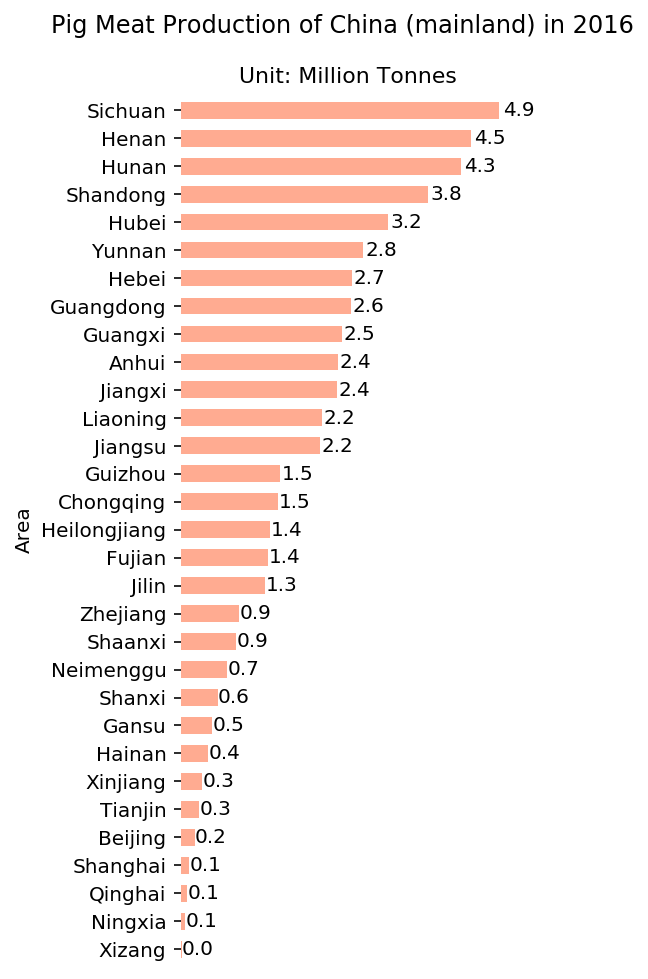

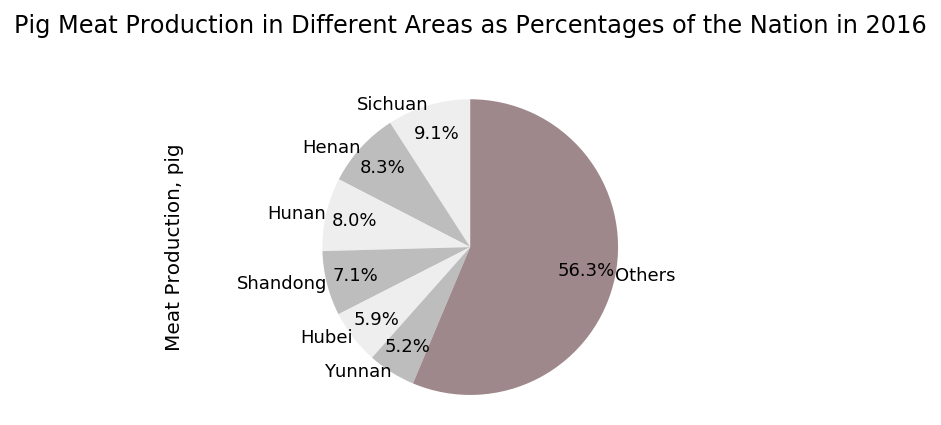

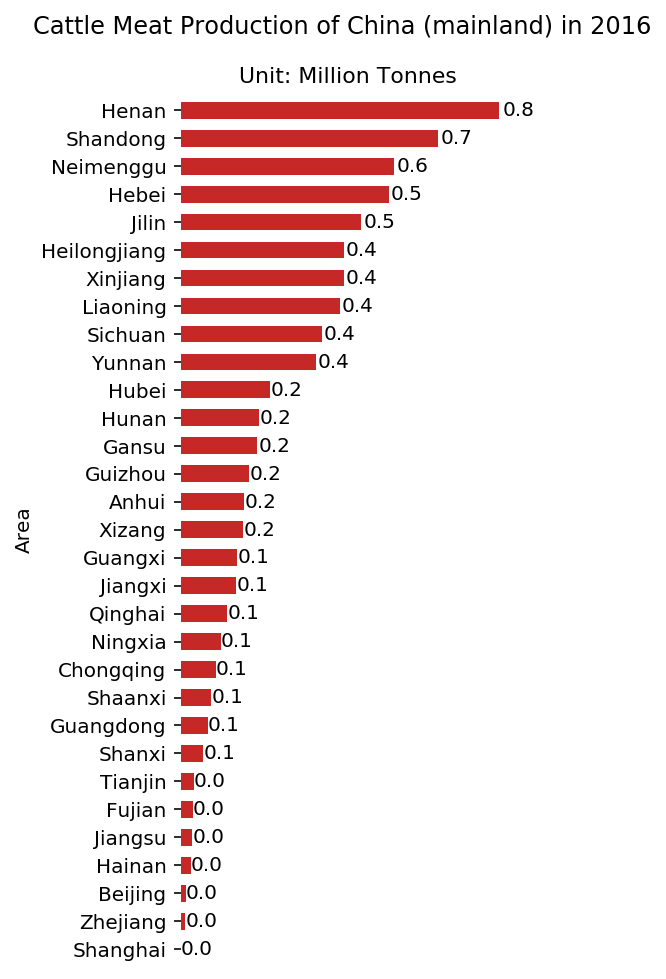

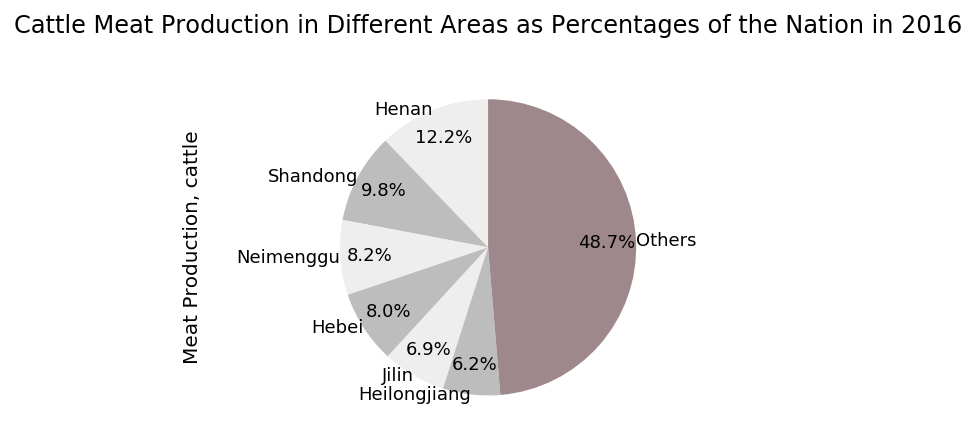

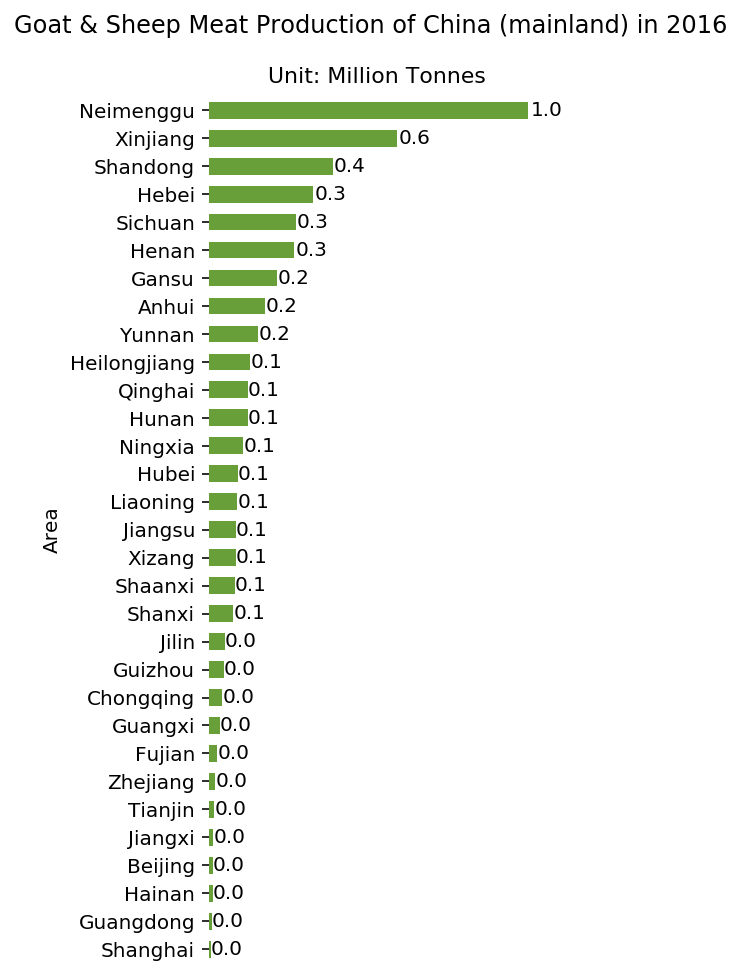

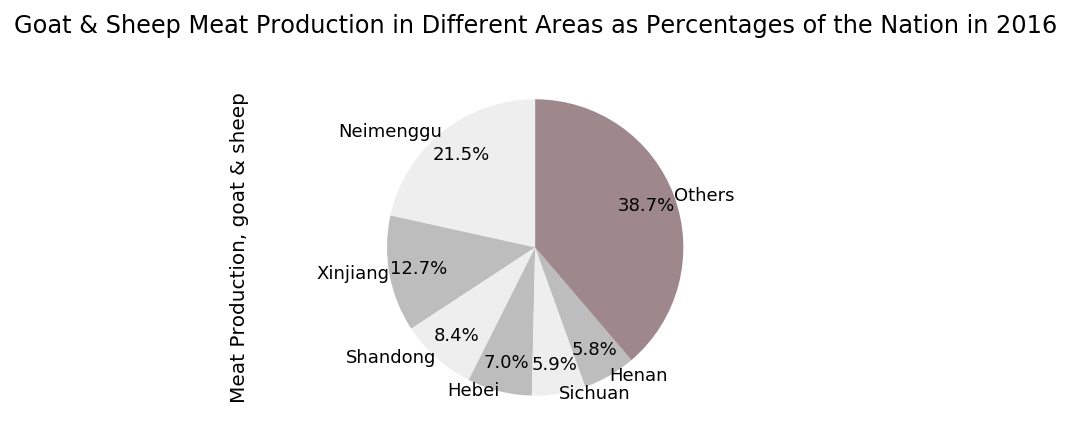

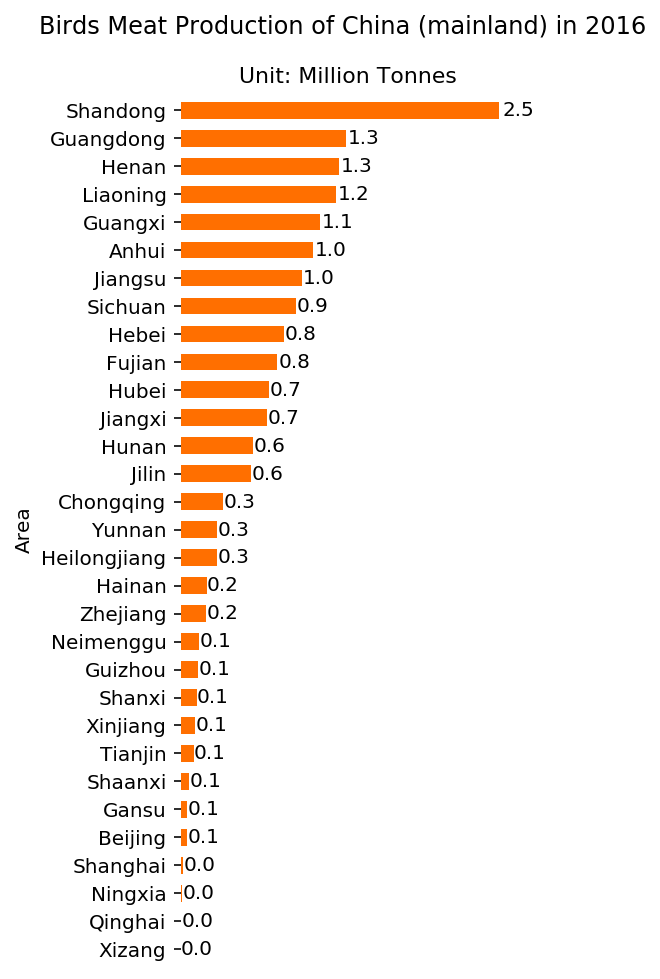

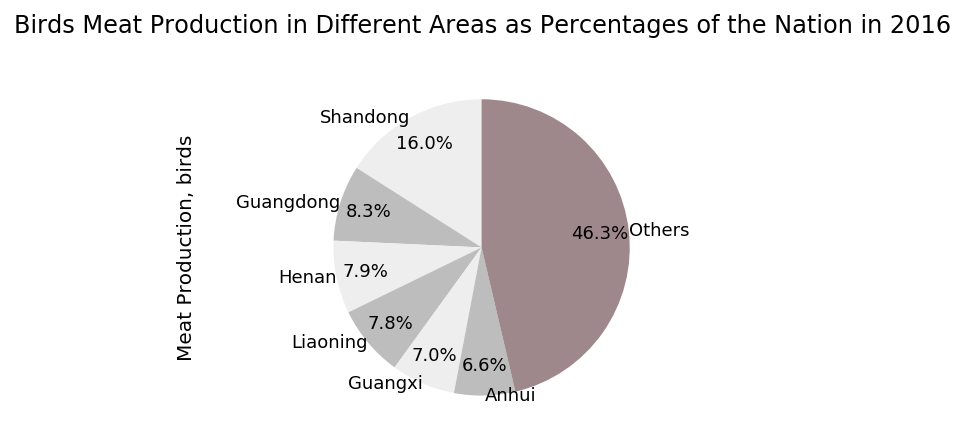

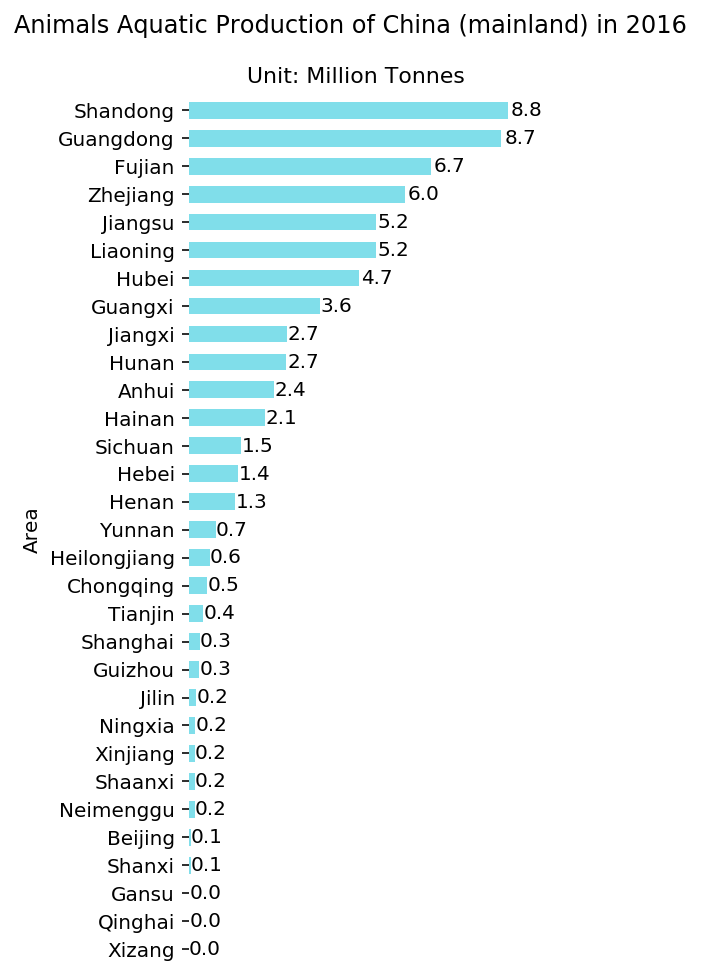

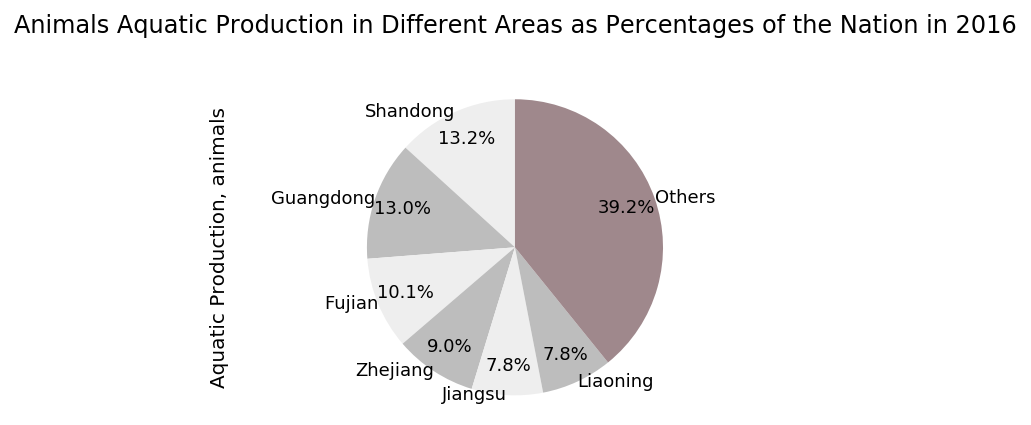

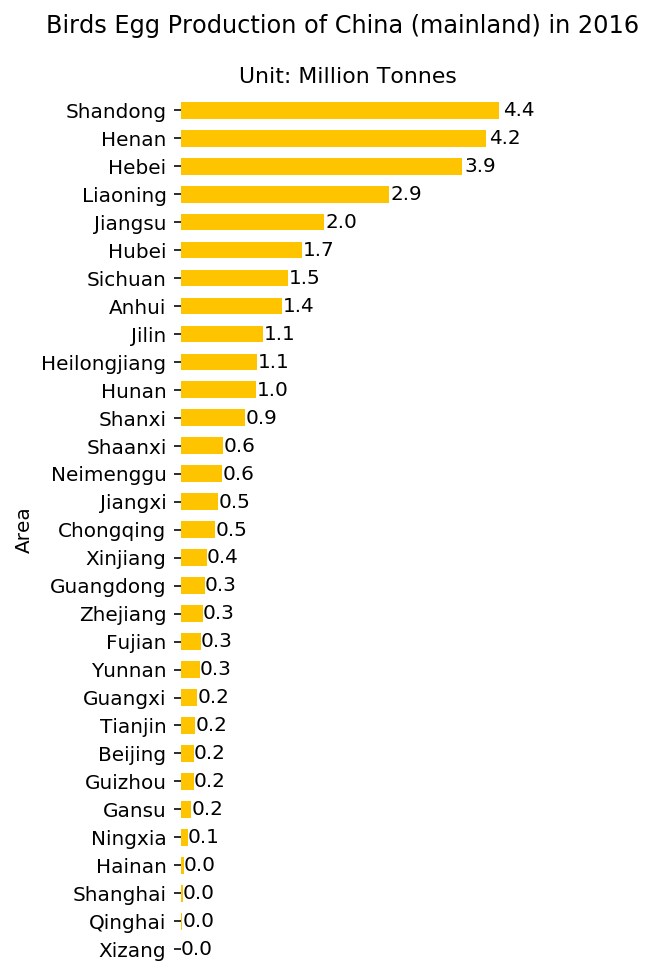

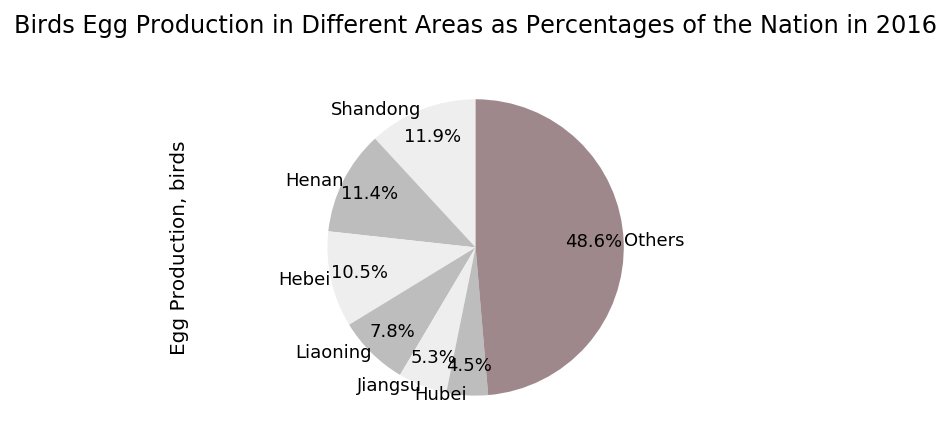

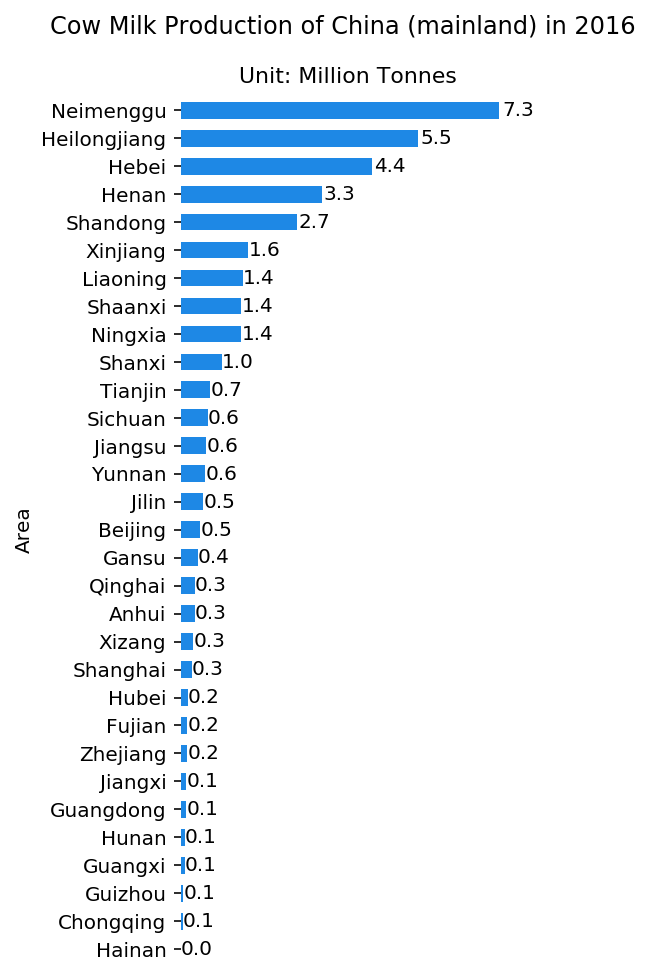

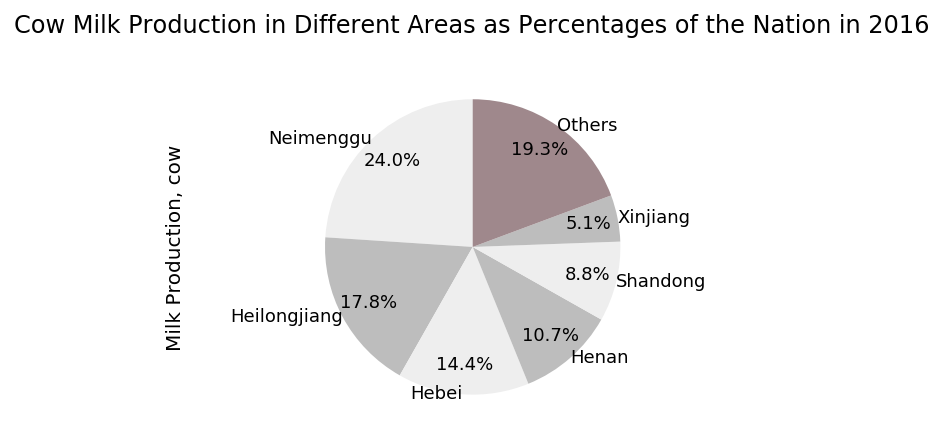

In [10]:
total_production(
    year = 2016,
)

In [11]:
def plotAtlas(
    items_,        # string, selected item
    year_,         # int, selected year
    geo_data_,     # geojson file
    fill_color_,   # string, select a fill_color strategy in folium
):

    df = DATA[['Area', 'Year']+Is].copy()
    df = df[(df['Year']==year_) & (~df['Area'].isin(['China, mainland']))][['Area']+items_]
    
    for i in items_:
        words = i.split(', ')
        title = f"Areas {words[1].title()} {words[0]} as Percentages of Nation ({year_})"
        cn_map = folium.Map( width=1000, height=600, location=[40, 105], zoom_start=4, tiles='Mapbox Bright')
        
        threshold_scale = np.around(np.linspace(0, df[i].values.max()+1, num=6, endpoint=True),0)
    
        folium.Choropleth(
            geo_data=geo_data_,
            data=df[['Area', i]],
            name = i,
            columns=['Area', i],
            key_on='feature.properties.NAME',
            threshold_scale=threshold_scale,
            nan_fill_color='gray',
            fill_color=fill_color_,
            fill_opacity=1, 
            line_opacity=0.2,
            legend_name=title,
            show=False,
            highlight=False,
            reset=False
        ).add_to(cn_map)
        
        path = f'{LOCAL_ROOT}/results/{domain}/map/02-{title}.html'
        cn_map.save(path)
        print('Atala saved as: ' + path)
#         display(cn_map)

In [12]:
plotAtlas(
    items_=Is,         # string, selected item
    year_=2016,         # int, selected year
    geo_data_=f'{LOCAL_ROOT}/geojson/cn_provinces.geojson',     # geojson file
    fill_color_='BuGn',   # string, select a fill_color strategy in folium
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/map/02-Areas Pig Meat Production as Percentages of Nation (2016).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/map/02-Areas Cattle Meat Production as Percentages of Nation (2016).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/map/02-Areas Goat & Sheep Meat Production as Percentages of Nation (2016).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/map/02-Areas Birds Meat Production as Percentages of Nation (2016).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/map/02-Areas Animals Aquatic Production as Percentages of Nation (2016).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/map/02-Areas Birds Egg Production as Percentages of Nation (2016).html
Atala saved as: /mnt/sda2/_hub

In [13]:
def plotProductivity(
    area_, 
    fig_size,
):
    
    items = ['pig', 'cattle', 'goat & sheep', 'birds']
    df=DATA[['Area', 'Year'] + Is + Is_productivity].copy()
    
    for i,c in zip(items, CLs):

        # items name
        item2 = 'Meat Production, '+i
        item11 = 'Stock, '+i
        item12 = 'Slaughtered, '+i
        item3 = 'Meat Yield, '+i
        
        # df made of selected items
        df_res = df[df['Area']==area_][['Year',item11,item12,item2,item3]]
        df_res[[item11,item12,item2]] = df_res[[item11,item12,item2]]/100    # 10,000  -> 1000,000
        
        # canvas and axes
        fig, ax = plt.subplots(figsize=fig_size, dpi=DPI)
        title = 'Main Indicators of {} Production'.format(i.title())
        plt.title(title, fontsize=TIT_size)
        
        ax2, ax3=ax.twinx(),ax.twinx()
        rspine = ax3.spines['right']
        rspine.set_position(('axes', 1.25))
        
        ax3.set_frame_on(True)
        ax3.patch.set_visible(False)
        fig.subplots_adjust(right=0.75)
        
        # === Meat Production
        df_res[['Year',item2]].plot(x='Year', color=c, ls='-', linewidth=2, ax=ax)
        ax.legend(
            labels=['Production'],
            loc='center left', frameon=False, fontsize=LEG_size,
            bbox_to_anchor=(1.5,0.65),borderaxespad = 0.,
        )
        ax.xaxis.label.set_visible(False)
        ax.yaxis.set_major_locator(plt.MaxNLocator(6))
        ax.set_ylim(0,)
        ax.set_ylabel('Meat Production (million tonnes)', fontsize=LAB_size) 


        # === Stock & Slaughtered
        df_res[['Year',item12]].plot(x='Year', color=Gray2, ls='--', linewidth=2,  ax=ax2)
        df_res[['Year',item11]].plot(x='Year', color=Gray2, ls=':', linewidth=2.5,  ax=ax2)
        ax2.legend(
            labels=['Slaughtered', 'Stock'],
            loc='center left', frameon=False, fontsize=LEG_size,
            bbox_to_anchor=(1.5,0.5),borderaxespad = 0.,
        )
        ax2.xaxis.label.set_visible(False)
        ax2.yaxis.set_major_locator(plt.MaxNLocator(6))
        ax2.set_ylim(0,)
        ax2.set_ylabel('Stock or Slaughtered (million heads)', fontsize=LAB_size) 

        
        # === Meat Yield
        df_res[['Year',item3]].plot(x='Year', color=Gray2, ls='-.', linewidth=2, ax=ax3)
        ax3.legend(
            labels=['Meat Yield'],
            loc='center left', frameon=False, fontsize=LEG_size,
            bbox_to_anchor=(1.5,0.35),borderaxespad = 0.,
        )
        ax3.xaxis.label.set_visible(False)
        ax3.yaxis.set_major_locator(plt.MaxNLocator(6))
        ax3.set_ylim(0,)
        ax3.set_ylabel('Meat Yield (kg/head)', fontsize=LAB_size) 
        
        # draw X ticks
        step=5
        X_ticks= list(range(1980,2020,step))

        # === Save img
        path = f'{LOCAL_ROOT}/results/CN_AnimalProduction/img/03-{title}.png'
        bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0]+2, fig_size[1]]])
        fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
        print('Img saved as: ' + path)

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/03-Main Indicators of Pig Production.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/03-Main Indicators of Cattle Production.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/03-Main Indicators of Goat & Sheep Production.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/03-Main Indicators of Birds Production.png


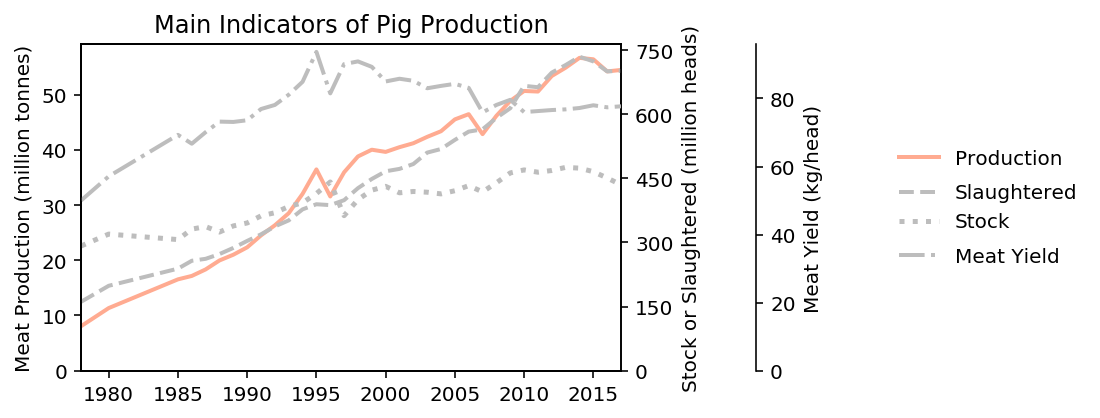

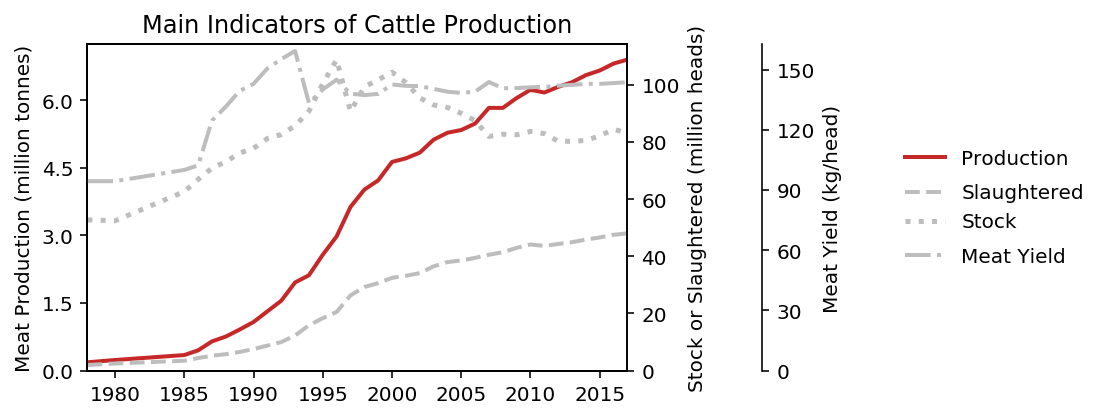

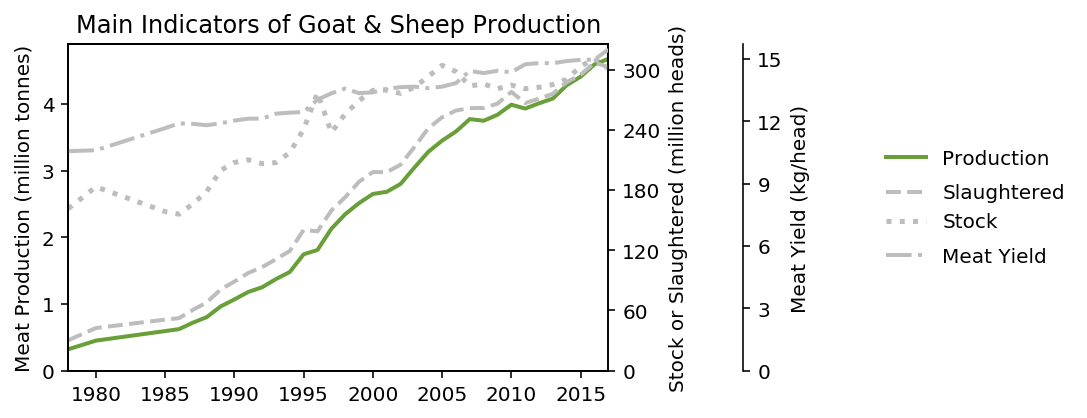

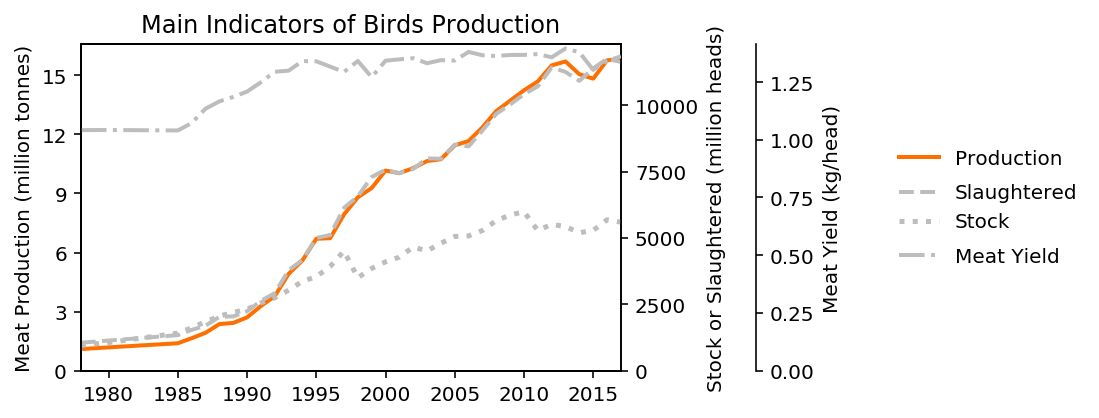

In [14]:
area = 'China, mainland'

plotProductivity(
    area_=area, 
    fig_size = (6,3),
)

In [15]:
def plotAquatic(
    area_,
    unit_='Million Tonnes',
):    
    
    items=Is_aquatic
    df=DATA[['Area', 'Year']+items].copy()
    
    df = df[df['Area']=='China, mainland'][['Year']+items]
    df['Sum'] = df[items].apply(lambda x: x.sum(), axis=1)
    df[items] = df[items]/100           # 10,000 -> 1,000,000
    
    df = df.dropna()

    display(df.head())

    X_step = 5
    X_ticks = range(1980, 2015+X_step, X_step)
    
    colors=[GF_blue1,GF_blue2, GF_green1,GF_green2]
    fig_size=FIG_size
    
    # === Line Plot                 
    title = "Captured and Aquacultured Aquatic in {}".format(area_) 
    sub_title = "Unit: Million Tonnes"
    fig = plt.figure(figsize = fig_size, dpi = DPI)
    plt.suptitle(title, fontsize=TIT_size, y=1.12)
    plt.title(sub_title, fontsize=TIT_size-1, y=1.1)
    
    df[['Year']+items].plot.line(x='Year',color=colors, ax=plt.gca())
    
    ax=plt.gca()
    ax.legend(frameon=False, loc='center left', fontsize=LEG_size,
              bbox_to_anchor=(1.,0.5),borderaxespad = 0.)
    ax.xaxis.label.set_visible(False)
    ax.set_ylim(0,)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.5)
    
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # === Save img
    path = f'{LOCAL_ROOT}/results/{domain}/img/04-{title}-line.png'
    bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0]+1.5, fig_size[1]+1]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)
    
    # ===================== Bar
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=1.12)
    plt.title(sub_title, fontsize=TIT_size-1, y=1.1)

    # Y Total for notation
    bot=np.zeros(len(X_ticks))
    for i in items:
        y = np.array(df[df['Year'].isin(X_ticks)][i]) 
        bot=bot + y
    totals = bot
    plt.bar(X_ticks, totals ,color="b", width=BAR_wid, alpha=0)

    # Notation
    ax = plt.gca()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:^.0f}'.format(height), (x+0.5, y+height+1), fontsize=LEG_size)

    # Stacked Y values
    bot=np.zeros(len(X_ticks))
    for i,c in zip(items, colors):
        y = np.array(df[df['Year'].isin(X_ticks)][i]) 
        plt.bar(X_ticks, y ,bottom=bot,color=c, width=BAR_wid)
        bot=bot + y
    totals = bot

    ax.set_ylim(0,)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.5)

    plt.yticks([])

    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(
        labels=[""]+items, 
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )
    
    # === Save img
    path = f'{LOCAL_ROOT}/results/{domain}/img/04-{title}-bar.png'
    bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0]+1.5, fig_size[1]+1]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)

    # ================ Bar Percentage
    title = "Percentages (%) of Captured and Aquacultured Aquatic in China (mainland)".format(area_)
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size-1, y=1.1)

    # Stacked Y values
    bot=np.zeros(len(X_ticks))
    for i,c in zip(items, colors):
        y = np.array(df[df['Year'].isin(X_ticks)][i])/totals*100
        plt.bar(X_ticks, y ,bottom=bot,color=c, width=BAR_wid)
        bot=bot + y

    ax = plt.gca()
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.5)
    ax.set_ylim(0,)

    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(
        labels=items, 
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )

    # === Save img
    path = f'{LOCAL_ROOT}/results/{domain}/img/04-{title}.png'
    bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0]+1.5, fig_size[1]+1]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)

,Year,"Marine, capture","Marine, aquac.","Freshwater, capture","Freshwater, aquac.",Sum
17,1978,3.1450,0.4530,0.2950,0.7620,465.50
19,1980,2.8130,0.4441,0.3397,0.9002,449.70
24,1985,3.4851,0.7123,0.4764,2.3777,705.15
25,1986,3.8960,0.8580,0.5380,2.9440,823.60
26,1987,4.3820,1.1000,0.6000,3.4720,955.40


Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/04-Captured and Aquacultured Aquatic in China, mainland-line.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/04-Captured and Aquacultured Aquatic in China, mainland-bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/04-Percentages (%) of Captured and Aquacultured Aquatic in China (mainland).png


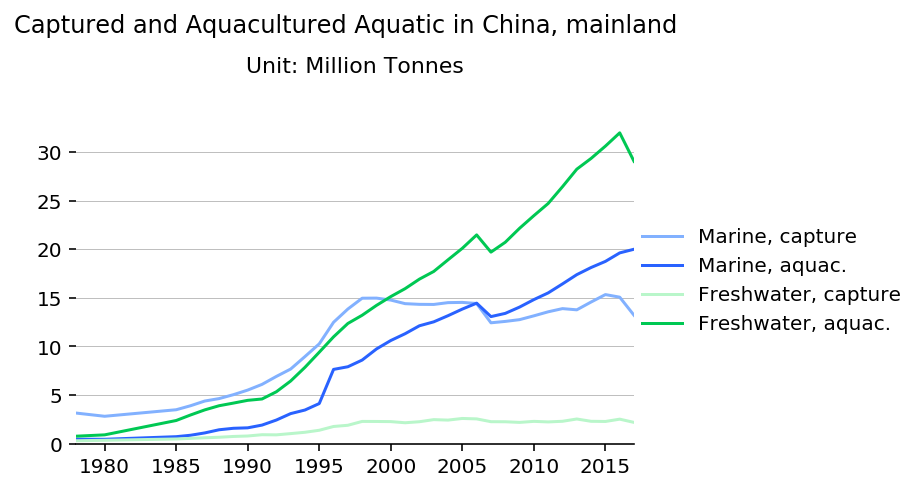

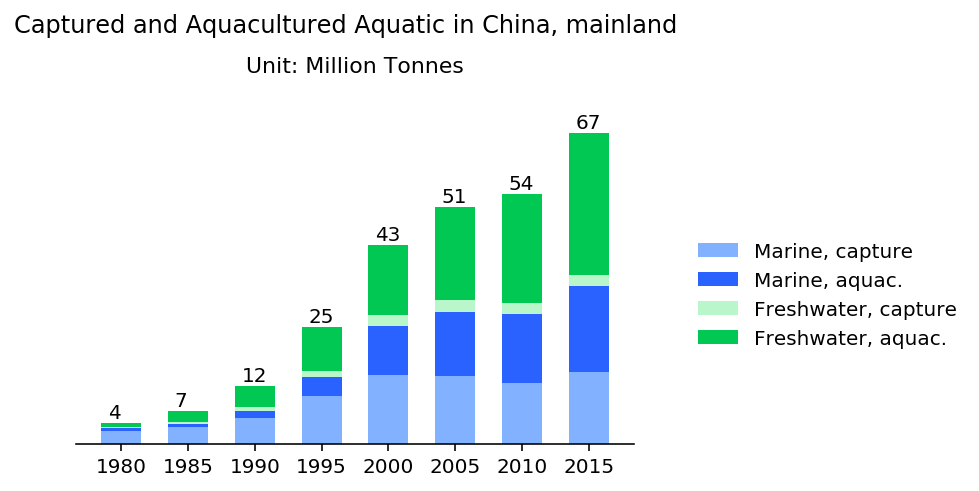

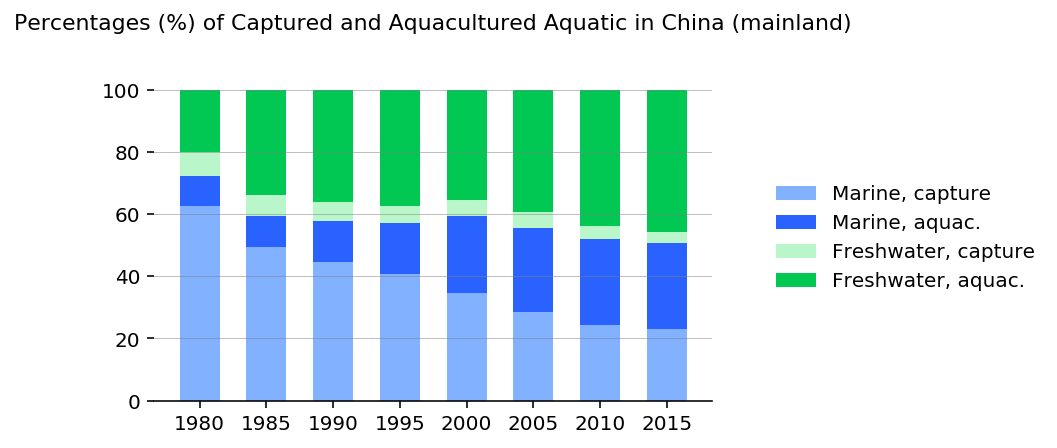

In [16]:
area = 'China, mainland'

plotAquatic(
    area_=area,
    unit_='Million Tonnes',
)